<a href="https://colab.research.google.com/github/lasseufpa/ml4comm/blob/main/qam_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Globecom Tutorial - December 7, 2021
Tutorial 29: Machine Learning for MIMO Systems with Large Arrays
Nuria Gonzalez-Prelcic (NCSU),
Aldebaro Klautau (UFPA) and
Robert W. Heath Jr. (NCSU)

# QAM classifiers

In [1]:
# Clone the repository if running in Colab and install all the dependencies
if 'google.colab' in str(get_ipython()):
    import sys
    import os
    try:
      !git clone https://github.com/lasseufpa/ml4comm.git
    except:
      print("ml4comm is already in the contents")
    !pip install -r /content/ml4comm/requirements.txt  &>/dev/null
    sys.path.append(os.path.abspath('/content/ml4comm'))

fatal: destination path 'ml4comm' already exists and is not an empty directory.


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from commpy.channels import SISOFlatChannel
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

from ml4comm.qam_crazy import crazy_channel_propagate
from ml4comm.qam_awgn import generate_symbols
from ml4comm.qam_analyzer import plot_decision_boundary, ser, plot_confusion_matrix
from ml4comm.classifiers_comparison import train_classifier
 
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Classifiers for QAM demodulation

### Variables

In [3]:
channel_type = 'crazy' # 'awgn' or 'crazy'
M            = 16      # QAM modulation
num_symbols  = 6000    # Number of transmitted symbols
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

### Generate QAM symbols and transmit them over the channel

In [4]:
# Generate the QAM symbols
symbs, indices = generate_symbols(num_symbols, M)

In [5]:
if channel_type == 'awgn':
    channel = SISOFlatChannel(None, (1 + 0j, 0j))
    channel.set_SNR_dB(SNR_dB, float(code_rate), Es)
    channel_output = channel.propagate(symbs)
elif channel_type == 'crazy':
    channel_output = crazy_channel_propagate(symbs, SNR_dB) 
else:
    raise ValueError(f'Channel type {channel_type} not found')

In [6]:
# Generate dataset
# Train
train_size = int(0.5*len(indices))
y_train = indices[:train_size]
X_train = np.stack([np.real(channel_output[:train_size]),
                    np.imag(channel_output[:train_size])], axis=1)

# Test
y_test = indices[train_size:]
X_test = np.stack([np.real(channel_output[train_size:]),
                   np.imag(channel_output[train_size:])], axis=1)

In [7]:
def plot_symbols():
    custom_cmap = cm.get_cmap('tab20')
    num_classes = M
    colors = custom_cmap.colors[:num_classes]
    levels = np.arange(num_classes + 2) - 0.5

    for ii in range(num_classes):
        selected_indices = np.argwhere(y_train==ii)
        selected_indices = selected_indices.reshape((-1))
        plt.plot(X_train[selected_indices, 0], X_train[selected_indices, 1], 'o', color=colors[ii], label=f'{ii}')
        
    plt.plot(np.real(symbs), np.imag(symbs), 'rx')
    plt.legend(title='Classes', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, handleheight=2, labelspacing=0.05, frameon=False)
    plt.ylabel('Quadrature')
    plt.xlabel('In-phase')

    plt.show()  

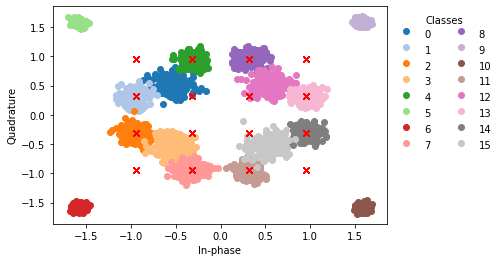

In [8]:
plot_symbols()

## Classifiers

### MLP

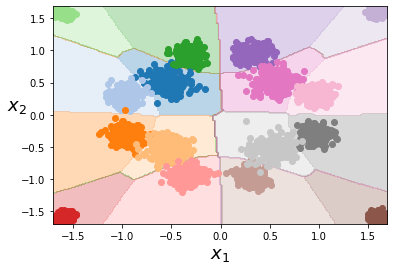

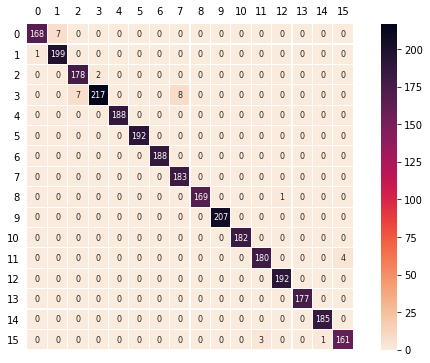

In [9]:
clf_MLP = train_classifier('Neural Net', X_train, y_train, M)
plot_decision_boundary(clf_MLP, X_train, y_train)
plot_confusion_matrix(clf_MLP, X_test, y_test, M)


In [10]:
%%time
scores = cross_val_score(clf_MLP, X_train, y_train, cv=10)
scores

CPU times: user 1min 25s, sys: 1min 15s, total: 2min 40s
Wall time: 1min 23s


In [12]:
#Predição do treino e teste

#MLP
print('MLP - Acurácia')
pred_train = clf_MLP.predict(X_train)
print('Treino:\t {:.2%}'.format(metrics.accuracy_score(y_train, pred_train)))
pred_test7 = clf_MLP.predict(X_test)
print('Teste:\t {:.2%}'.format(metrics.accuracy_score(y_test, pred_test7)))
print('--'*12)

print('SYMBOL ERROR RATE - SER')

#MLP
print('MLP - SER')
ser_test = ser(clf_MLP, X_test, y_test)
print('SER:{:.2%}'.format(ser_test))
print('--'*12)



MLP - Acurácia
Treino:	 98.67%
Teste:	 98.87%
------------------------
SYMBOL ERROR RATE - SER
MLP - SER
SER:1.13%
------------------------
